In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from huggingface_hub import hf_hub_download


2025-12-10 09:46:43.138635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 09:46:43.516128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 09:46:47.368426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/camilo/Downloads/IA medicos/IAMedicos/.venv/lib/python3.12/site-packages/tqdm/auto.py

In [3]:
CLASS_NAMES = ["akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASS_NAMES)}
IMG_SIZE = (224, 224)  # as described in the model card [web:1][web:5]


In [4]:
# download skin_cancer_model.h5 from HF repo syaha/skin_cancer_detection_model [web:1][web:4]
model_path = hf_hub_download(
    repo_id="syaha/skin_cancer_detection_model",
    filename="skin_cancer_model.h5"
)

model = load_model(model_path)


2025-12-10 09:46:55.051163: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_dir(root_dir):
    images = []
    labels = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            path = os.path.join(class_dir, fname)
            if not os.path.isfile(path):
                continue
            try:
                img = load_img(path, target_size=IMG_SIZE)
                arr = img_to_array(img) / 255.0  # normalize as in typical Keras workflow [web:1][web:5]
                images.append(arr)
                labels.append(CLASS_TO_IDX[class_name])
            except Exception:
                # Optional: log or skip unreadable files
                continue

    if not images:
        raise ValueError(f"No images found under {root_dir}")
    x = np.stack(images, axis=0)
    y = np.array(labels)
    return x, y


In [6]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

def evaluate_fitz_dataset(root_dir, name, batch_size=32):
    x, y = load_images_from_dir(root_dir)
    y_cat = to_categorical(y, num_classes=len(CLASS_NAMES))

    num_samples = x.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    loss_batches = []
    acc_batches = []

    all_labels = []
    all_preds = []
    all_probs = []

    for b in range(num_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, num_samples)
        xb = x[start:end]
        yb = y_cat[start:end]

        probs = model.predict(xb, verbose=0)
        batch_loss = loss_fn(yb, probs).numpy()

        preds = np.argmax(probs, axis=1)
        labels = np.argmax(yb, axis=1)

        batch_acc = (preds == labels).mean()

        loss_batches.append(float(batch_loss))
        acc_batches.append(float(batch_acc))

        all_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    avg_loss = float(np.mean(loss_batches))
    avg_acc = float(np.mean(acc_batches))
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print(f"[{name}] Loss: {avg_loss:.4f}")
    print(f"[{name}] Acc:  {avg_acc:.4f}")
    print(f"[{name}] P/R/F1 (macro): {precision:.4f}/{recall:.4f}/{f1:.4f}")

    return {
        "name": name,
        "loss_batches": loss_batches,
        "acc_batches": acc_batches,
        "avg_loss": avg_loss,
        "avg_acc": avg_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "labels": all_labels,
        "preds": all_preds,
        "probs": all_probs,
    }


In [8]:
paths = {
    "Fitz_12": "../test_dataset/12",
    "Fitz_34": "../test_dataset/34",
    "Fitz_56": "../test_dataset/56",
}

results = {}
for name, p in paths.items():
    results[name] = evaluate_fitz_dataset(p, name)


[Fitz_12] Loss: 5.1329
[Fitz_12] Acc:  0.1125
[Fitz_12] P/R/F1 (macro): 0.0740/0.1904/0.0909
[Fitz_34] Loss: 4.9205
[Fitz_34] Acc:  0.1028
[Fitz_34] P/R/F1 (macro): 0.0934/0.1098/0.0636
[Fitz_56] Loss: 4.1121
[Fitz_56] Acc:  0.2311
[Fitz_56] P/R/F1 (macro): 0.1794/0.1733/0.1187


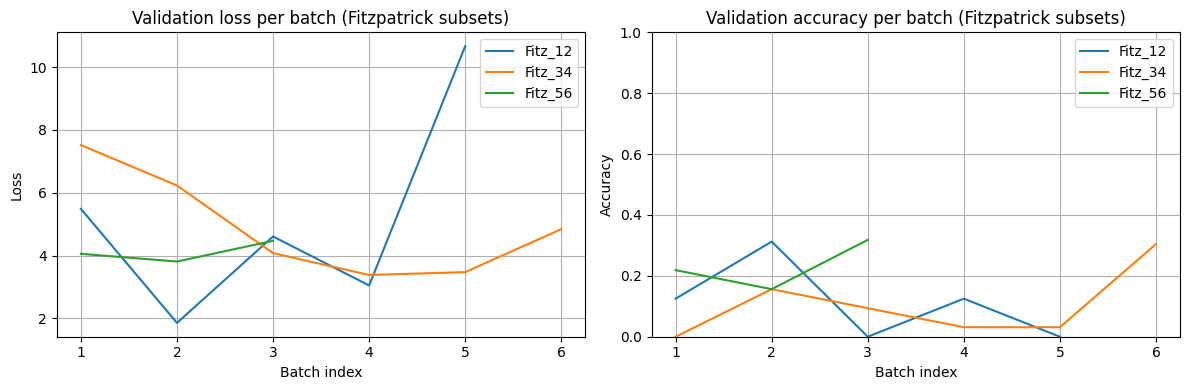

In [9]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
for name, res in results.items():
    steps = range(1, len(res["loss_batches"]) + 1)
    plt.plot(steps, res["loss_batches"], label=name)
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.title("Validation loss per batch (Fitzpatrick subsets)")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
for name, res in results.items():
    steps = range(1, len(res["acc_batches"]) + 1)
    plt.plot(steps, res["acc_batches"], label=name)
plt.xlabel("Batch index")
plt.ylabel("Accuracy")
plt.title("Validation accuracy per batch (Fitzpatrick subsets)")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


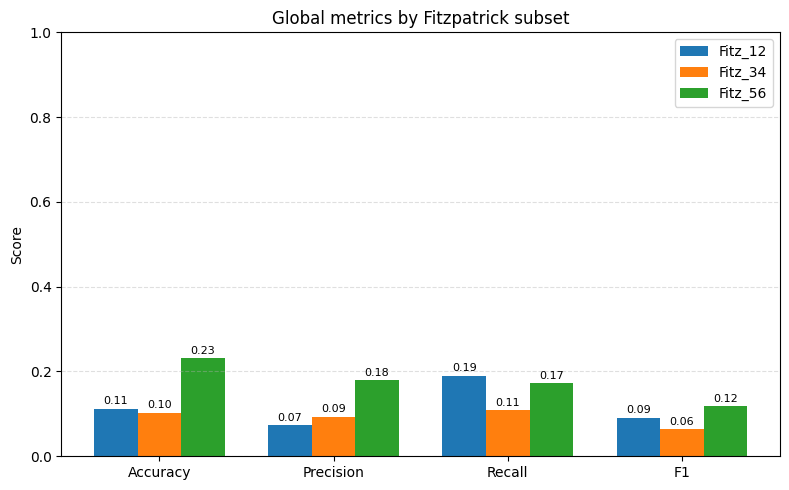

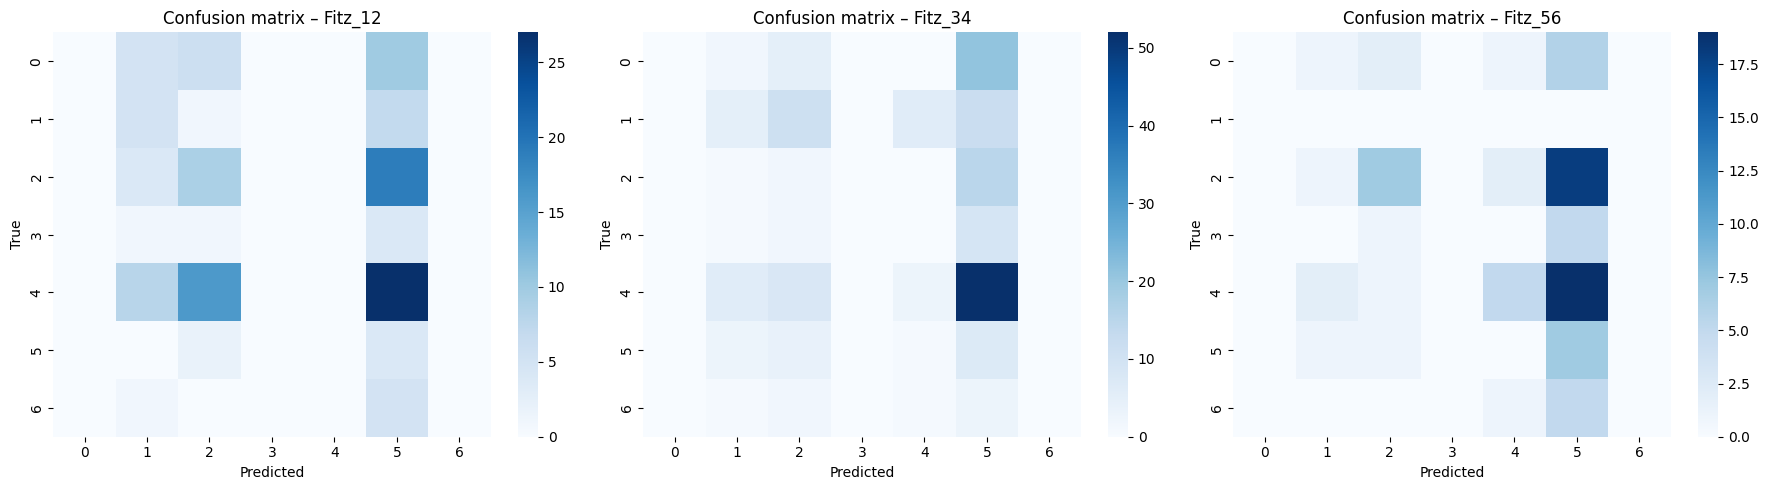

In [10]:
# grouped metrics
datasets_names = list(results.keys())
metrics_names = ["Accuracy", "Precision", "Recall", "F1"]

metric_matrix = np.array([
    [results[n]["avg_acc"], results[n]["precision"], results[n]["recall"], results[n]["f1"]]
    for n in datasets_names
])

x = np.arange(len(metrics_names))
width = 0.25

plt.figure(figsize=(8, 5))
for i, name in enumerate(datasets_names):
    plt.bar(x + i * width, metric_matrix[i], width=width, label=name)

plt.xticks(x + width, metrics_names)
plt.ylim(0, 1)
for i in range(len(datasets_names)):
    for j in range(len(metrics_names)):
        v = metric_matrix[i, j]
        plt.text(x[j] + i * width, v + 0.01, f"{v:.2f}", ha="center", fontsize=8)

plt.title("Global metrics by Fitzpatrick subset")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# per-dataset confusion matrices
num_sets = len(results)
plt.figure(figsize=(6 * num_sets, 5))
for idx, (name, res) in enumerate(results.items(), start=1):
    cm = confusion_matrix(res["labels"], res["preds"])
    plt.subplot(1, num_sets, idx)
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix – {name}")
plt.tight_layout()
plt.show()
